In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis Dataset/df-1 (1).csv',encoding =('ISO-8859-1'))
pd.set_option('display.max_colwidth', -1)
df = df.reset_index(drop=True)
#df = df[[1,7]]
df.columns = ['Reviews','Level','Sentiment']
df.head()

,Reviews,Level,Sentiment
0,Make a version of dark theme,Mobile banking,Neutral
1,I can easily make my urgent transactions using bKash app. Thanks to all the members of bKash team.,Mobile banking,Positive
2,My Sister Going through Tough time Collecting Our Parents Money From This Bank Dilkusha Brunch.When im Staying Overseas im bit Helpless and Both Of Our Parents Passed way Last Year at Pandemic. Your Kind Appreciation will help instead of Showing your Achievement or Activities . I try to Go through Direct Cell Number which wasn't Helpful so without having any other better option i comment here to get the Attention of Authority. Hope they Have Solution for My Problem,Commercial Banking,Negative
3,"This app is very disappointed for me, coz maximum time when I try to open this app It's not open yet! I try to Fixed it , sometimes I just uninstall this app & try to open again but its not work actually!! Ã°Å¸ËÂ¡Ã°Å¸ËÂ¡",Mobile banking,Negative
4,"Would you please give me the details of the house loan, my home is Rangpur Sadar Rangpur",Commercial Banking,Neutral


In [ ]:
df['Reviews']=df['Reviews'].astype(str)

In [ ]:
# text length
df['text_length'] = df['Reviews'].apply(len)
df[['Sentiment','text_length','Reviews']].head()

,Sentiment,text_length,Reviews
0,Neutral,28,Make a version of dark theme
1,Positive,98,I can easily make my urgent transactions using bKash app. Thanks to all the members of bKash team.
2,Negative,469,My Sister Going through Tough time Collecting Our Parents Money From This Bank Dilkusha Brunch.When im Staying Overseas im bit Helpless and Both Of Our Parents Passed way Last Year at Pandemic. Your Kind Appreciation will help instead of Showing your Achievement or Activities . I try to Go through Direct Cell Number which wasn't Helpful so without having any other better option i comment here to get the Attention of Authority. Hope they Have Solution for My Problem
3,Negative,222,"This app is very disappointed for me, coz maximum time when I try to open this app It's not open yet! I try to Fixed it , sometimes I just uninstall this app & try to open again but its not work actually!! Ã°Å¸ËÂ¡Ã°Å¸ËÂ¡"
4,Neutral,88,"Would you please give me the details of the house loan, my home is Rangpur Sadar Rangpur"


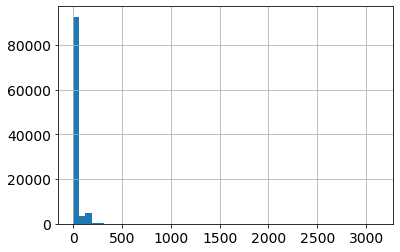

In [ ]:
df['text_length'].hist(bins=50)

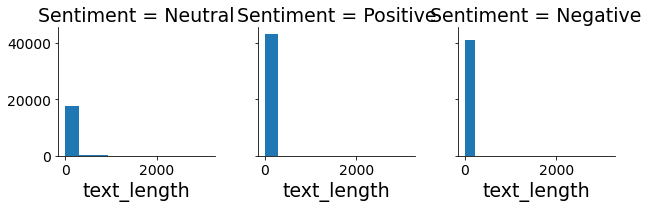

In [ ]:
g = sns.FacetGrid(df,col='Sentiment')
g.map(plt.hist,'text_length')

In [ ]:
# Encode Categorical Variable
X = df['Reviews']
y = pd.get_dummies(df['Sentiment']).values
num_classes = df['Sentiment'].nunique()
y

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [ ]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(81888,) (20472,) (81888, 3) (20472, 3)


In [ ]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

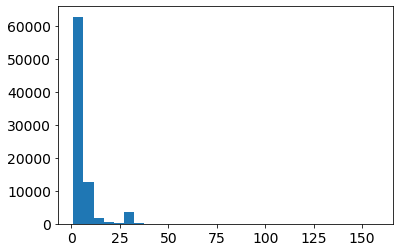

In [ ]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [ ]:
from keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)


(81888, 30) (20472, 30)


In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 5

In [ ]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)
    # plot train history
    plot_model_history(model_history)

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
def model_evaluate(): 
    # predict class with test set
    predictions = (model.predict(X_test) > 0.5)*1
    y_pred_test = np.argmax(predictions).flatten()
    #y_train_labels = y_train_labels.reshape(-1,1)
    y_pred_test  = y_pred_test.reshape(-1,1)
   # y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_test,axis=0))*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

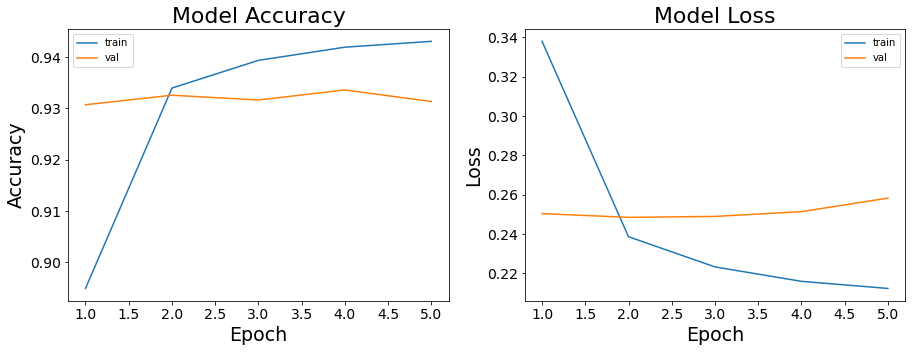

In [ ]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

In [ ]:
model.evaluate(X_test,y_test)


640/640 [==============================] - 3s 5ms/step - loss: 0.2583 - accuracy: 0.9313


[0.2582898437976837, 0.93132084608078]

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix,classification_report

In [ ]:
#METRICS FUNCTION

def report(model):
    preds =model.predict(X_test)
    print(classification_report(y_test,preds> 0.5))
   

In [ ]:
report(model)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      8172
           1       0.95      0.76      0.84      3639
           2       0.98      0.95      0.96      8661

   micro avg       0.93      0.93      0.93     20472
   macro avg       0.94      0.90      0.91     20472
weighted avg       0.94      0.93      0.93     20472
 samples avg       0.93      0.93      0.93     20472



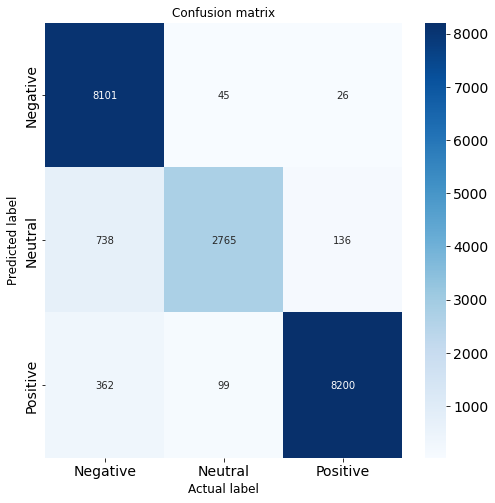

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=12)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)